<a href="https://colab.research.google.com/github/IsabelJoseph101/image_classification_brain_tumor/blob/master/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain tumor detection (CNN)

The aim of this project is to develop a convolutional neural network (CNN) that is able to accurately classify if a patient has a tumor or not based on images of MRI scans.

To solve this binary classification problem I will be preforming several iterations of the neural network modelling process in order to improve on the preformance by going through the following process:

1) Data pre-processing for NN
2) Comparing performance across different types of NN
3) Hyperparameter tuning on each type
4) Increasing image quality of quantity if necessary

From there I will then select a winning model and then preform threshold selection on it. Given the binary nature of this image classification issue, I be adopting ROC score as my main metric to measure good performance throughout the modelling. Other metrics such as F1 and Accuracy will also be added within the final evaluation of the winning model.

### Importing necessary packages

In [1]:
# importing necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import Sequential
from keras import layers
from keras.layers import *
from keras.layers import Dense
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.backend.tensorflow_backend import set_session

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.utils import shuffle #shuffling the data improves the model

from glob import glob
import os
from os import listdir
from mlxtend.plotting import plot_confusion_matrix
from tqdm import tqdm
import cv2
import shutil
import itertools
import imutils

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D

init_notebook_mode(connected=True)
RANDOM_SEED = 123

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


### Loading the data

About the data: The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous andno contains 98 Brain MRI Images that are non-tumorous.

In [2]:
# unzipping the file containing the data
!unzip data.zip

Archive:  data.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 no.jpg  
  inflating: brain_tu

In [49]:
# loading images of MRI scans
image_dir = "brain_tumor_dataset/"

In [50]:
os.listdir(f'{image_dir}')

['yes', 'no']

In [5]:
# creating recursive directories
os.makedirs('../output/kaggle/working/augmented-images')
os.makedirs('../output/kaggle/working/augmented-images/yes')
os.makedirs('../output/kaggle/working/augmented-images/no')

In [51]:
# creating a function that transforms the data
def augment_data(file_dir, n_generated_samples, save_to_dir):

  '''
  '''

  data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

  for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshaping the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [52]:
augmented_data_path = '../output/kaggle/working/augmented-images/'

In [53]:
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')

In [54]:
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

### Pre-processing the data

In [55]:
yes_generator_base = ImageDataGenerator(rescale= 1./255).flow_from_directory(
        augmented_data_path+'no', 
        target_size=(500,500),
        batch_size = 1500,
        color_mode = 'grayscale',
        seed = 12
        )

Found 0 images belonging to 0 classes.


OpenCV will be used to crop the image around the tumors where it will find the extreme points in contours 

In [56]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

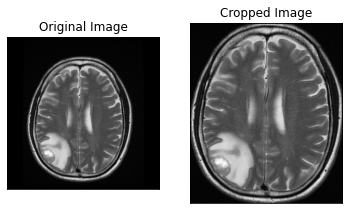

In [57]:
# checking the result of the cropped images
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [58]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

In [ ]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [ ]:
plot_sample_images(X, y)

#TRAIN, VALIDATION AND TEST SPLIT

In [ ]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2)

In [ ]:
# check X and Y shapes
print('X train Shape:', X_train.shape)
print('y train Shape:', y_train.shape)
print('-----------------------------------------')
print('X validation Shape:', X_val.shape)
print('y validation Shape:', y_val.shape)
print('-----------------------------------------')
print('X test Shape:', X_test.shape)
print('y test Shape:', y_test.shape)

From the results obtained with the shape, for the X train it can be seen that the first value represents the amount of images (e.g. 1651), then the next two values represent the shape of the image (e.g. 240x240) and the last value represents the channels (e.g. 3)

#FUNCTIONS FOR ROC_SCORE AND VISUALIZATIONS

Due to the fact that roc_score cannot be calculated in mini-batches, we need to create a custom function that measures roc_score at the end of each epoch. Also, implementing a visualisation function for loss, accuracy and roc_score.

In [ ]:
# function for roc_score
def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [ ]:
# function for visualisations
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_auroc'])
    plt.plot(history['auroc'])
    plt.legend(['val_auroc', 'auroc'])
    plt.title('roc_auc')
    plt.xlabel('epochs')
    plt.ylabel('roc_auc')
    plt.show()

#BASELINE MODEL

As baseline model, we'll be using a simple Dense layer model. Dense layers are usually not the preferred choice when it comes to image recognition as they are not able to detect pattern in a 'geometric' way in the same way CNN do with horizontal and vertical lines. The input_size for a Dense NN is simply a vector long as the size of the image multiplied by the different layers. In our case, this would 500 width x 500 height x 1 layer (because we pre-processed the images to be in grayscale)

In [22]:
# checking for new shapes
print(X_train.shape)

(1650, 240, 240, 3)


In [ ]:
image_dir2 = "brain_tumor_dataset/"

In [23]:
# gaussian blurring and grayscaling!!! and 64x64
# getting all the images in the directory training/normal and reshape them to 600 pixels
train_generator_base = ImageDataGenerator(rescale= 1./255).flow_from_directory(
        image_dir2, 
        target_size=(500,500),
        batch_size = 1500,
        color_mode = 'grayscale',
        seed = 12
        )


Found 253 images belonging to 2 classes.


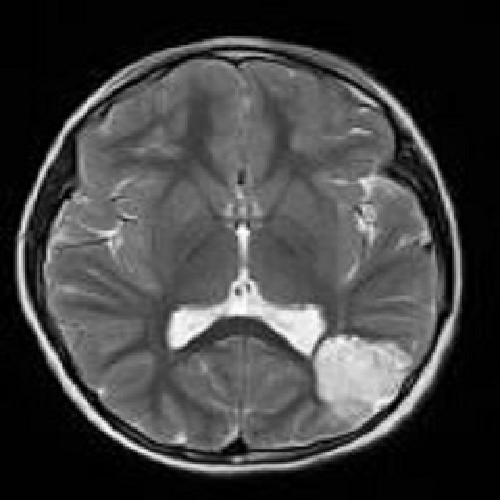

In [24]:
# create the datasets
train_images, train_labels = next(train_generator_base)
array_to_img(train_images[0])

In [25]:
# looking at the dataset shapes of all our images

print('------------data')
print(train_images.shape)

print('-----------target')
print(train_labels.shape)

------------data
(253, 500, 500, 1)
-----------target
(253, 2)


In [26]:
# We need to transform our training and validation dataset into a (1500, 500x500x1) and (300, 500x500x1) respectively

train_img_dense = train_images.reshape(500,-1)

In [27]:
# checking for new shapes
print(train_img_dense.shape)

(500, 126500)


In [28]:
# double-checking what tuple corresponds to each class 
print(train_generator_base.class_indices)

{'no': 0, 'yes': 1}


In [29]:
# reshaping the train and test labels with 1 corresponding to positive to pneumonia
train_labels_final = train_labels.T[[1]].T

In [30]:
print(train_labels_final.shape)

(253, 1)


#INITIAL BASELINE MODEL DENSE LAYER NEURAL NETWORK

We chose as the baseline model a Dense Neural Network with only one single layer with 20 nodes. Activation function chosen is relu while we have to keep the final activation function as a sigmoid since we have a binary classification problem.

In [42]:
# instatiating a sequential model
model = Sequential()

In [43]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [44]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())

In [45]:
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [46]:
# compiling the model
model.compile(loss='binary_crossentropy', 
                optimizer='sgd', 
                metrics=['accuracy', auroc])

In [48]:
# fitting the model
results_1 = model.fit(X_train, y_train,
           epochs = 10,
           batch_size = 32)

ValueError: ignored

In [ ]:
visualize_training_results(results_1)

#MODEL 2

In [ ]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0   

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
46/46 [==============================] - 122s 3s/step - loss: 0.8853 - accuracy: 0.6025 - val_loss: 0.6304 - val_accuracy: 0.7129
Epoch 2/22
46/46 [==============================] - 121s 3s/step - loss: 0.5196 - accuracy: 0.7493 - val_loss: 0.6171 - val_accuracy: 0.6613
Epoch 3/22
46/46 [==============================] - 122s 3s/step - loss: 0.4586 - accuracy: 0.7825 - val_loss: 0.5339 - val_accuracy: 0.7935
Epoch 4/22
46/46 [==============================] - 122s 3s/step - loss: 0.3808 - accuracy: 0.8345 - val_loss: 0.5020 - val_accuracy: 0.8000
Epoch 5/22
46/46 [==============================] - 122s 3s/step - loss: 0.3279 - accuracy: 0.8733 - val_loss: 0.5064 - val_accuracy: 0.7677
Epoch 6/22
46/46 [==============================] - 122s 3s/step - loss: 0.3208 - accuracy: 0.8650 - val_loss: 0.4732 - val_accuracy: 0.7839
Epoch 7/22
46/46 [==============================] - 122s 3s/step - loss: 0.3262 - accuracy: 0.8463 - val_loss: 0.4363 - val_accuracy: 0.7968
Epoch 8/22
46

In [ ]:
history = model.history.history

Plotting accuracy

In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

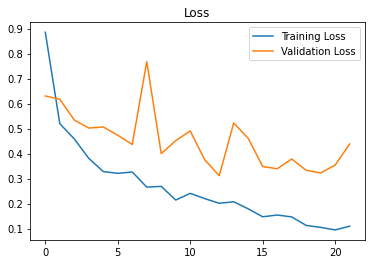

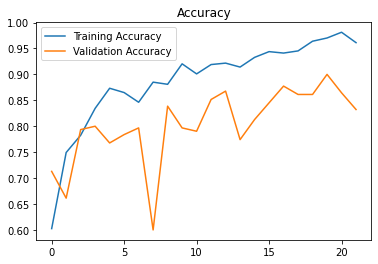

In [ ]:
plot_metrics(history)